In [254]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

import gc
from time import time
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import random
import pickle
import pathlib

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
import glob

tensorboard = TensorBoard(log_dir='./logs/{}'.format(time()))

In [231]:
classes = ['adult_females', 'adult_males', 'juveniles', 'pups', 'subadult_males']
train_dir = './input/train'
test_dir = './input/test'

In [232]:
train_females = [f'./input/train/{i}' for i in os.listdir(train_dir) if "adult_females" in i]
train_males = [f'./input/train/{i}' for i in os.listdir(train_dir) if "adult_males" in i]
train_juveniles = [f'./input/train/{i}' for i in os.listdir(train_dir) if "juveniles" in i]
train_pups = [f'./input/train/{i}' for i in os.listdir(train_dir) if "pups" in i]
train_sub_males = [f'./input/train/{i}' for i in os.listdir(train_dir) if "subadult" in i]


test_females = [f'./input/test/{i}/' for i in os.listdir(test_dir) if "adult_females" in i]
test_males = [f'./input/test/{i}' for i in os.listdir(test_dir) if "adult_males" in i]
test_juveniles = [f'./input/test/{i}' for i in os.listdir(test_dir) if "juveniles" in i]
test_pups = [f'./input/test/{i}' for i in os.listdir(test_dir) if "pups" in i]
test_sub_males = [f'./input/test/{i}' for i in os.listdir(test_dir) if "subadult" in i]

In [233]:
train_imgs = train_females[0:1000] + train_males[0:1500] + train_juveniles[0:1500] + train_pups[0:1500] + train_sub_males
train_imgs = list(dict.fromkeys(train_imgs))
test_imgs = test_females[0:300] + test_females[0:300] + test_juveniles[0:300] + test_pups[0:300] + test_sub_males[0:300]
test_imgs = list(dict.fromkeys(test_imgs))
random.shuffle(train_imgs)

In [234]:
trash = [train_females, train_males, train_juveniles, train_pups, train_males]
for i in trash: del i
gc.collect()

42157

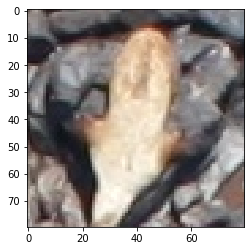

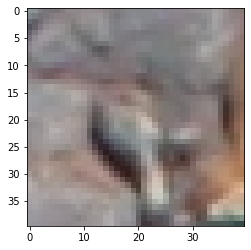

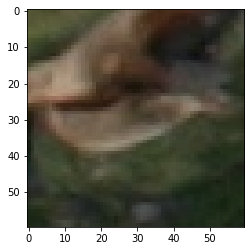

In [235]:
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img = mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [236]:
# Declare image dimensions, using colored images
nrows = 100
ncolumns = 100
channels = 3

In [266]:
# Function to read and process the images to an acceptable format for the model
def read_and_process_image(list_of_images):
    """
    Returns two arrays:
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        try:
            X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC)) #Read img
            #print(X)
            # get the labels
            if 'adult_females' in image:
                y.append(0)
            elif '_adult_males' in image:
                y.append(1)
            elif 'juveniles' in image:
                y.append(2)
            elif 'pups' in image:
                y.append(3)
            elif 'subadult_males' in image:
                y.append(4)
                #print('sa found')
            print(image)
        except:
            continue
        
    return X, y

In [238]:
X, y = read_and_process_image(train_imgs)

[0, 3, 2, 3, 2]


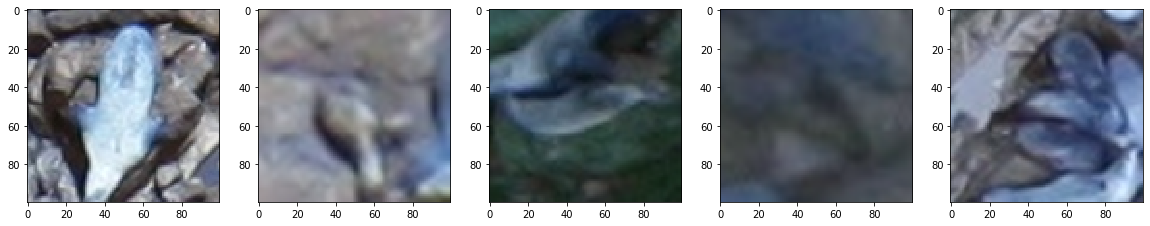

In [239]:
# Verify a few
print(y[:5])
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

Text(0.5, 1.0, 'Labels for Sea Lion Classes')

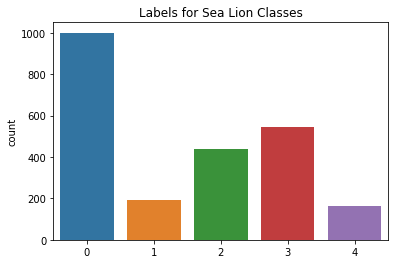

In [240]:
import seaborn as sns
del train_imgs
gc.collect()

X = np.array(X)
y = np.array(y)

# Plot the label to be sure we just have five classes
sns.countplot(y)
plt.title('Labels for Sea Lion Classes')

In [241]:
np.unique(y)

array([0, 1, 2, 3, 4])

In [242]:
# Let's split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.20, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (1872, 100, 100, 3)
Shape of validation images is: (468, 100, 100, 3)
Shape of labels is: (1872,)
Shape of labels is: (468,)


In [243]:
# Clear memory
del X
del y
gc.collect()

10

In [244]:
ntrain = len(X_train)
nval = len(X_val)

batch_size = 32          # should be a factor of 2

In [245]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [246]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) #dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax')) 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 128)         147584    
__________

In [247]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [248]:
# Let's create the augmentation configuration
# This helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255) #don't augment validation data, just rescale

In [249]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [250]:
# Create the generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [255]:
# Training part - train for 64 epochs with about 100 steps per epoch

history = model.fit_generator(train_generator,
                             steps_per_epoch = ntrain // batch_size,
                             epochs = 100,
                             validation_data = val_generator,
                             validation_steps = nval // batch_size,
                             callbacks=[tensorboard])

W1009 15:30:14.585799 16936 deprecation_wrapper.py:119] From C:\Users\604572\Continuum\anaconda3\envs\MaskRCNN\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1009 15:30:14.587794 16936 deprecation_wrapper.py:119] From C:\Users\604572\Continuum\anaconda3\envs\MaskRCNN\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/100
58/58 [==============================] - 4s 66ms/step - loss: 1.0089 - acc: 0.6105 - val_loss: 0.9420 - val_acc: 0.63071.0088 - acc:
Epoch 2/100
58/58 [==============================] - 4s 64ms/step - loss: 1.0366 - acc: 0.5878 - val_loss: 0.8823 - val_acc: 0.6284
Epoch 3/100
58/58 [==============================] - 4s 65ms/step - loss: 0.9995 - acc: 0.6029 - val_loss: 0.9256 - val_acc: 0.6216
Epoch 4/100
58/58 [==============================] - 4s 64ms/step - loss: 0.9722 - acc: 0.6250 - val_loss: 0.8389 - val_acc: 0.6445
Epoch 5/100
58/58 [==============================] - 4s 63ms/step - loss: 0.8994 - acc: 0.6379 - val_loss: 0.7901 - val_acc: 0.6468
Epoch 6/100
58/58 [==============================] - 4s 63ms/step - loss: 0.9156 - acc: 0.6363 - val_loss: 0.8264 - val_acc: 0.6518
Epoch 7/100
58/58 [==============================] - 4s 64ms/step - loss: 0.9394 - acc: 0.6320 - val_loss: 0.8550 - val_acc: 0.6628oss: 0.9274 - acc:
Epoch 8/100
58/58 [==========================

In [256]:
# Save the model

model.save_weights('model_weights.h5')
model.save('model_keras.h5')

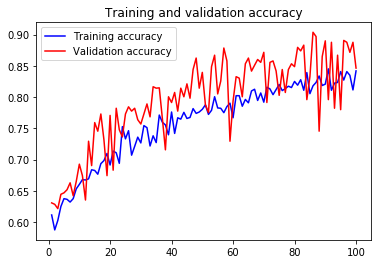

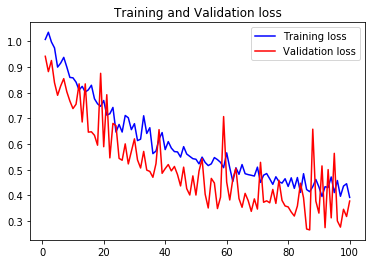

In [257]:
# Plot the train and val curve, getting details from history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Train and val accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [267]:
# Finally predict on the first 10 images of the test set
random.shuffle(test_imgs)
X_test, y_test = read_and_process_image(test_imgs[0:20]) #Y_test in this case will be empty
x = np.array(X_test)

print(y_test)
test_datagen = ImageDataGenerator(rescale=1./255)

./input/test/43_pups_184.png
./input/test/44_juveniles_74.png
./input/test/49_juveniles_146.png
./input/test/43_pups_79.png
./input/test/43_pups_64.png
./input/test/43_pups_131.png
./input/test/47_pups_273.png
./input/test/48_juveniles_113.png
./input/test/43_pups_218.png
./input/test/48_juveniles_134.png
[3, 2, 2, 3, 3, 3, 3, 2, 3, 2]


predictions = [[9.3616865e-05 7.1725972e-11 2.0413077e-02 9.7949320e-01 1.3337139e-07]]
highest probability = 0.9794932
highest probability index/class= [3]
--------------------
predictions = [[1.7330664e-01 2.0101032e-05 8.2292891e-01 2.7733883e-03 9.7101618e-04]]
highest probability = 0.8229289
highest probability index/class= [2]
--------------------
predictions = [[1.1787804e-01 3.1811651e-05 8.6493742e-01 1.6698515e-02 4.5419295e-04]]
highest probability = 0.8649374
highest probability index/class= [2]
--------------------
predictions = [[7.82689025e-09 3.15245447e-17 1.09605835e-05 9.99989033e-01
  7.46957766e-14]]
highest probability = 0.99998903
highest probability index/class= [3]
--------------------
predictions = [[0.15110081 0.00156831 0.83014643 0.01428265 0.00290176]]
highest probability = 0.83014643
highest probability index/class= [2]
--------------------
predictions = [[8.4905201e-05 1.8019010e-09 1.7661221e-02 9.8225373e-01 1.3454634e-07]]
highest probability = 0.9822

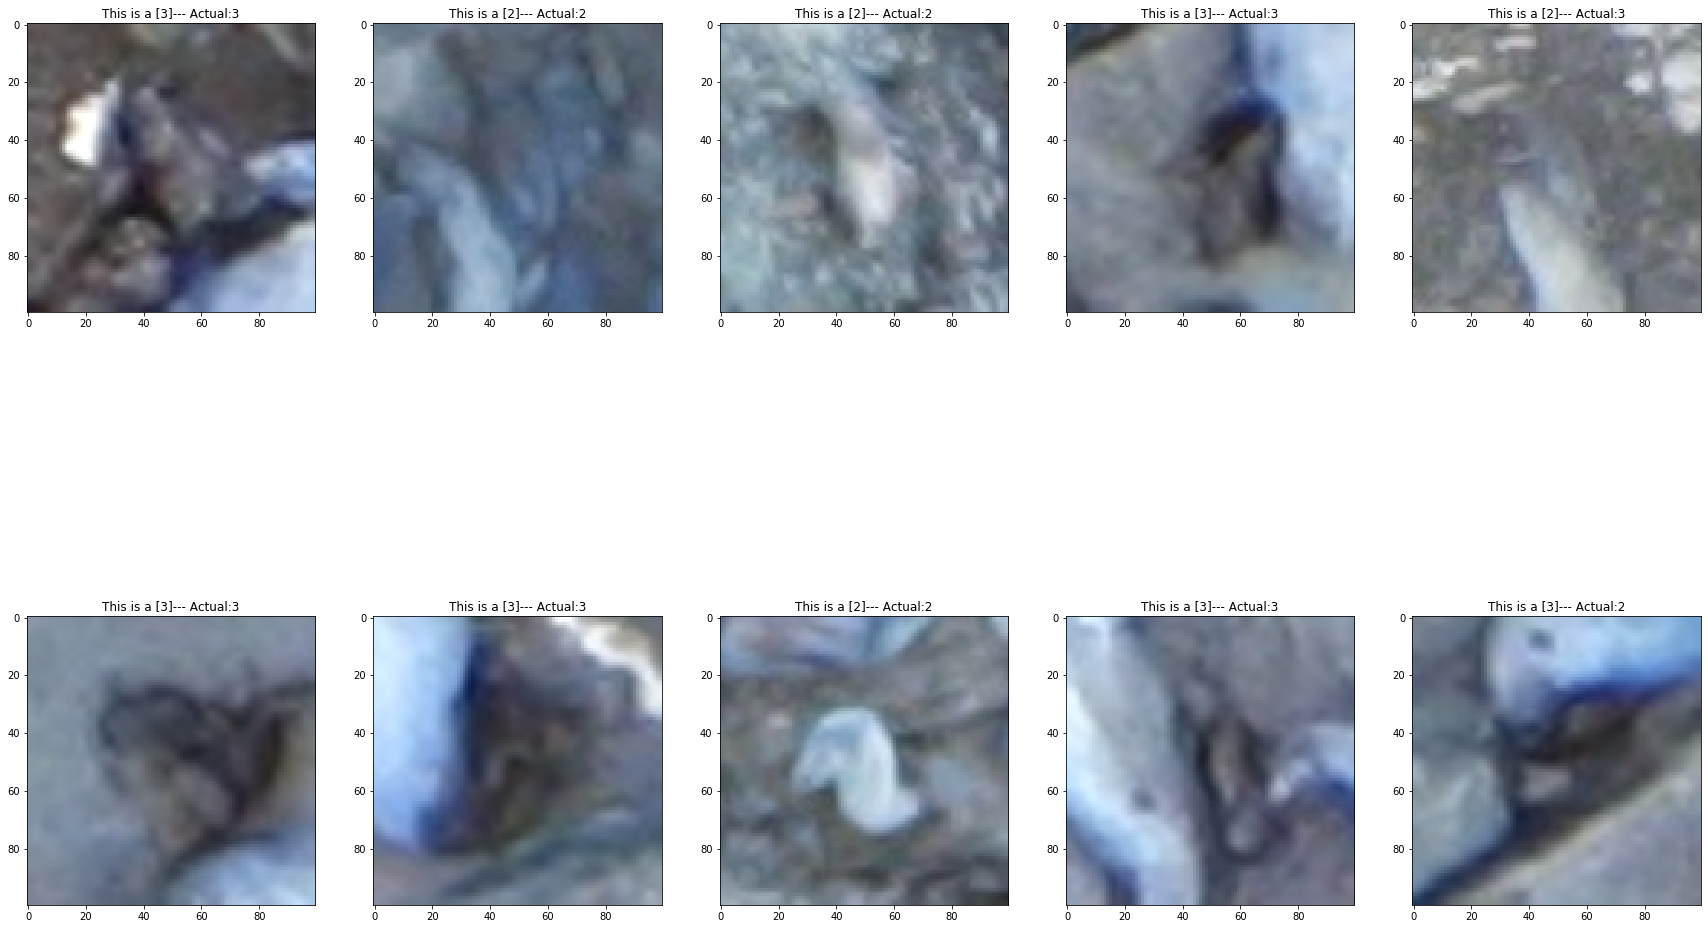

In [268]:
i = 0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    print("predictions =", pred)
    print("highest probability =", pred.max())
    highest = np.where(pred == pred.max())
    print("highest probability index/class=", highest[1])
    text_labels.append(f'{highest[1]}--- Actual:{y_test[i]}')
    print('-'*20)
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + str(text_labels[i]))
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()